In [37]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# 1. Importing  Data

In [38]:
list1 = pd.read_csv('listings.csv')
list2 = pd.read_csv('listings2.csv')
nbhd = pd.read_csv('neighbourhoods.csv')
calendar = pd.read_csv('calendar.csv')
review1 = pd.read_csv('reviews.csv')
review2 = pd.read_csv('reviews2.csv')
amenities = pd.read_csv('Cata Feature CSV/amenities.csv')
Integrate = pd.read_csv('Cata Feature CSV/IntegrateCata.csv')
amenities.shape
property_type = pd.read_csv('property_type.csv')
property_type.shape

(3818, 16)

#  2. Data Exploratory Analysis

In [39]:
# print(list1.columns.values)
# print(list1.shape)

In [40]:
# print(list2.columns.values)
# print(list2.shape)

In [41]:
# Join list1 and list2 to create the x vector
X = pd.concat([list1, list2], axis=1)
# print(X.shape)
# X.info(verbose = True, null_counts = True)

In [42]:
X=X[X['property_type'].notnull()]
X['property_type'].unique()
# Increasing the feature space
i=0
for item in X['property_type'].unique():
    a=X['property_type'] == X['property_type'].unique()[i]
    X[item] = a.map(lambda x: 1 if x == True else 0)
    i=i+1
X.shape

(3817, 124)

In [43]:
Z1=X.loc[:, X.dtypes == np.float64] #Extracting columns with values of type float 
Z2=X.loc[:, X.dtypes == np.int64]   #Extracting columns with values of type int
Z3=X.loc[:, X.dtypes == np.object]   #Extracting columns with values of type categorical
X_numeric=pd.concat([Z1,Z2], axis=1)
X_cat = Z3
X_numeric.shape
# X_numeric.head()

(3817, 56)

In [44]:
"""X_numeric has duplicate columns. The code below removes the duplicate columns"""
_, i = np.unique(X_numeric.columns, return_index=True)
X_Num_Cov=X_numeric.iloc[:, i]
X_Num_Cov.to_csv('Numerical_FS.csv')

In [45]:
_, i = np.unique(X_cat.columns, return_index=True)
X_cat=X_cat.iloc[:, i]
# print(X_cat.describe())
# print(X_cat.info())
X_cat.to_csv('Catgorical_FS.csv')

# Creating X and Y for the dataset

In [46]:
X_select = X_Num_Cov[['reviews_per_month','accommodates','bathrooms','bedrooms','beds','guests_included','latitude','longitude','price']]
X_select['avail'] = list2[['availability_365']]
X_select = pd.concat([X_select, amenities, Integrate, property_type], axis=1)
X_select = X_select.dropna()
Y = X_select['reviews_per_month']
X_select = X_select.drop(['reviews_per_month','Unnamed: 0'], axis = 1)
# print(X_select.info())
# X_select.columns
# X_select.info(verbose = True, null_counts = True)


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index([u'accommodates', u'bathrooms', u'bedrooms', u'beds', u'guests_included',
       u'latitude', u'longitude', u'price', u'avail', u'24-Hour Check-in',
       ...
       u'Townhouse', u'Loft', u'Boat', u'Bed & Breakfast', u'Other', u'Dorm',
       u'Treehouse', u'Yurt', u'Chalet', u'Tent'],
      dtype='object', length=229)

# Splitting data into training and testing sets

In [47]:
num_test = 0.1
X_train, X_test, y_train, y_test = train_test_split(X_select, Y, test_size=num_test, random_state=23)
X_train.shape
# X_test.shape
# property_type.head()

,Apartment,House,Cabin,Condominium,Camper/RV,Bungalow,Townhouse,Loft,Boat,Bed & Breakfast,Other,Dorm,Treehouse,Yurt,Chalet,Tent
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Learning Curve

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Ridge Regression with Validation Curve

0.28810192291


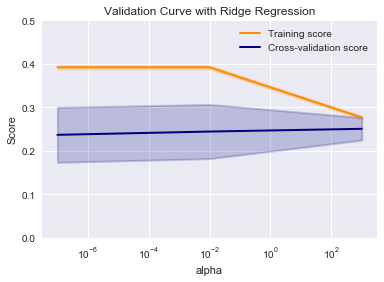

In [67]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)
print(clf.score(X_test, y_test))


param_range = np.logspace(-7, 3, 3)
# train_scores, test_scores = validation_curve(
#     Ridge(), X_select, Y, param_name="alpha", param_range=param_range,
#     cv=10, scoring="accuracy", n_jobs=1)
train_scores, test_scores = validation_curve(Ridge(), X_select, Y, "alpha",param_range,cv=10, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 0.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Linear Regression

0.283033865097


<module 'matplotlib.pyplot' from '/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

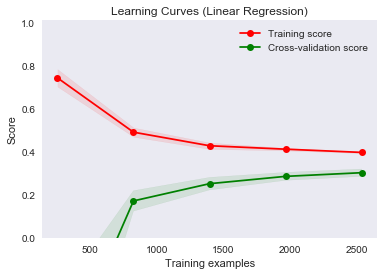

In [63]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))
regr.get_params()
regr.coef_

title = "Learning Curves (Linear Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = regr
plot_learning_curve(estimator, title, X_select, Y, (0, 1.01), cv=cv, n_jobs=4)

# Elastic Net

In [70]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
# print(regr.coef_) 
# print(regr.intercept_) 
# print(regr.predict([[0, 0]])) 
regr.score(X_test, y_test)

0.048597894124210672

# SVR

In [ ]:
from sklearn import svm
clf_svm=svm.SVR(kernel='linear')
clf_svm.fit(X_train,y_train)
clf_svm.score(X_test,y_test)

# Random Forest

In [71]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='float', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
print(clf.feature_importances_)
Y_pred = clf.predict(X_test)
clf.score(X_test, y_test)


ValueError: Unknown label type: 'continuous'

In [49]:
# X.describe(include=['O'])

In [50]:
X.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,Townhouse,Loft,Boat,Bed & Breakfast,Other,Dorm,Treehouse,Yurt,Chalet,Tent
0,241032,Stylish Queen Anne Apartment,956883,NaN,Queen Anne,West Queen Anne,47.636289,-122.371025,Entire home/apt,85,...,0,0,0,0,0,0,0,0,0,0
1,953595,Bright & Airy Queen Anne Apartment,5177328,Andrea,Queen Anne,West Queen Anne,47.639123,-122.365666,Entire home/apt,150,...,0,0,0,0,0,0,0,0,0,0
2,3308979,New Modern House-Amazing water view,16708587,NaN,Queen Anne,West Queen Anne,47.629724,-122.369483,Entire home/apt,975,...,0,0,0,0,0,0,0,0,0,0
3,7421966,Queen Anne Chateau,9851441,NaN,Queen Anne,West Queen Anne,47.638473,-122.369279,Entire home/apt,100,...,0,0,0,0,0,0,0,0,0,0
4,278830,Charming craftsman 3 bdm house,1452570,NaN,Queen Anne,West Queen Anne,47.632918,-122.372471,Entire home/apt,450,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Extract the Y vector


In [52]:
print(nbhd.columns.values)
print(nbhd.shape)

['neighbourhood_group' 'neighbourhood']
(90, 2)


In [53]:
print(review1.columns.values)
print(review1.shape)

['listing_id' 'date']
(84849, 2)


In [54]:
print(review2.columns.values)
print(review2.shape)

['listing_id' 'id' 'date' 'reviewer_id' 'reviewer_name' 'comments']
(84849, 6)


In [55]:
print(calendar.columns.values)
print(calendar.shape)
calendar.head()

['listing_id' 'date' 'available' 'price']
(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [ ]:
newlist1= list1.drop(['host_name', 'last_review','host_id','calculated_host_listings_count'], axis=1)
newlist1.head()

In [ ]:
list2['averating'] = list2[["review_scores_checkin", "review_scores_accuracy","review_scores_communication", "review_scores_location","review_scores_value", "review_scores_cleanliness"]].mean(axis=1)
ax = sns.regplot(x="averating", y="review_scores_rating", data=list2)

In [ ]:
yy = pd.DataFrame()
yy['review_scores_rating'] = list2['review_scores_rating']
xx = pd.DataFrame()
xx['host_response_rate'] = list2['host_response_rate']
# print(math.isnan(xx['host_response_rate'][3]))
for i in xrange(xx.shape[0]):
    if isinstance(xx['host_response_rate'][i], basestring):
        xx['host_response_rate'][i] = 1.0*int(xx['host_response_rate'][i][:-1])
combine = pd.concat([xx,yy], axis=1)
combine = combine.dropna()

print(combine.tail)
ax = sns.regplot(x='host_response_rate', y="review_scores_rating", data=combine)# 